#### Nahin Imtiaz
#### Homework 3

## Executive Summary
In this homework, I worked with ASSISTments dataset (RQ1, the non-skill builder dataset) to predict student performance. To be specific, we tried to predict whether a student will be able to correctly answer (0,1) a problem or not based on previous data about the problem such as the type of the problem, opportunity to practice that problem, amount of hints used, operlap time etc. In my initial exploratory data analization, I found out that there is a negative correlation between 'opportunity' and overlap time. As opportunity to practice a problem increases, it takes less overtime for a student to solve it.I also found out that the dataset has a very small portion of 'choose_n' and 'rank' type problem rows. This can make our model biased if we use this feature and we will not be able to correctly predict data that has 'choose_n' and 'rank' type problem in them.So I emitted this column for our model training.

I have used 4 different models- LogisticRegression, RandomForestClassifier, Neural Network ,and LSTM. I found out that the RandomForest model has the highest roc_auc score among all of them. I noticed that LSTM model had a high accuracy for testing datasets and low accuracy for training datasets which is surprising because usually we expect the model to have a lower accuracy when we test with test data.

Overall, these models can be used in predicting future performaces for a student and can help improve specific parts of their study style ie. having more opportunity to practice may increase their chances of getting a problem correct.

In [1]:
import pandas as pd

df = pd.read_csv('non_skill_builder_data_new.zip')
df.head()

,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,...,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original
0,20223588,245748,77759,12914,12914,1,1.0,1,57310.0,tutor,...,0,0,57310,12914,20935.0,NaN,0.0,NaN,1,1
1,20223595,245748,77759,15320,15320,1,1.0,1,88691.0,tutor,...,0,0,88691,15320,22385.0,NaN,0.0,NaN,2,2
2,20223601,245748,77759,14529,14529,1,1.0,1,43748.0,tutor,...,0,0,43748,14529,20735.0,NaN,0.0,NaN,3,3
3,20223926,245698,77912,1159,1159,1,0.0,2,45587.0,tutor,...,0,0,53599,1159,NaN,3,0.0,NaN,1,1
4,20223934,245698,77912,1647,1647,1,1.0,1,90176.0,tutor,...,0,0,90176,1647,3438.0,NaN,0.0,NaN,1,1


## Data Exploration

In [2]:
df.columns

Index(['order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id',
       'original', 'correct', 'attempt_count', 'ms_first_response',
       'tutor_mode', 'answer_type', 'sequence_id', 'student_class_id',
       'position', 'type', 'base_sequence_id', 'skill_id', 'skill_name',
       'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time',
       'template_id', 'answer_id', 'answer_text', 'first_action',
       'bottom_hint', 'opportunity', 'opportunity_original'],
      dtype='object')

In [3]:
df.dtypes

order_id                  int64
assignment_id             int64
user_id                   int64
assistment_id             int64
problem_id                int64
original                  int64
correct                 float64
attempt_count             int64
ms_first_response       float64
tutor_mode               object
answer_type              object
sequence_id               int64
student_class_id          int64
position                  int64
type                     object
base_sequence_id          int64
skill_id                 object
skill_name               object
teacher_id                int64
school_id                 int64
hint_count                int64
hint_total                int64
overlap_time              int64
template_id               int64
answer_id               float64
answer_text              object
first_action            float64
bottom_hint             float64
opportunity              object
opportunity_original     object
dtype: object

##### Since our dataset has some categorical features, we will turn them into numerical values so we can use these features in our model training.

I have created three numeric features from three categorical features. I am not sure if they count as new features or not. Since features have to be "non-trivial", I cannot aggregate a column and make a new feature from it since, it already has the information in it and the features are connected.

In [4]:
# Source - https://pbpython.com/categorical-encoding.html

from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
df["tutor_mode_cat"]= ord_enc.fit_transform(df[["tutor_mode"]])
df["answer_type_cat"]= ord_enc.fit_transform(df[["answer_type"]])
df["type_cat"]= ord_enc.fit_transform(df[["type"]])
df.head()

,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,...,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original,tutor_mode_cat,answer_type_cat,type_cat
0,20223588,245748,77759,12914,12914,1,1.0,1,57310.0,tutor,...,12914,20935.0,NaN,0.0,NaN,1,1,3.0,1.0,1.0
1,20223595,245748,77759,15320,15320,1,1.0,1,88691.0,tutor,...,15320,22385.0,NaN,0.0,NaN,2,2,3.0,1.0,1.0
2,20223601,245748,77759,14529,14529,1,1.0,1,43748.0,tutor,...,14529,20735.0,NaN,0.0,NaN,3,3,3.0,1.0,1.0
3,20223926,245698,77912,1159,1159,1,0.0,2,45587.0,tutor,...,1159,NaN,3,0.0,NaN,1,1,3.0,0.0,4.0
4,20223934,245698,77912,1647,1647,1,1.0,1,90176.0,tutor,...,1647,3438.0,NaN,0.0,NaN,1,1,3.0,1.0,4.0


Now we can take the important features and make a new dataframe. Note that we will drop some features if we find them unnecessary.

In [5]:
new_df = df[["order_id","user_id","problem_id", "original", "correct", "attempt_count", "ms_first_response", "tutor_mode_cat", "answer_type_cat", 
             "sequence_id", "position", "type_cat", "skill_id", "teacher_id", "school_id","hint_count", 
             "hint_total", "overlap_time", "first_action", "bottom_hint", "opportunity","opportunity_original"]]

We can see that some of the columns have strings consisting of numeric values seperated by comma. So now, we have to explode them and make new rows. Note that, the (i.e. skill_id, opportunity) are aslo related to each other. If a skill cell have 2 int values, the opportunity cell also have 2 values and so on.

In [6]:
# Source - https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows
new_df=(new_df.set_index(["order_id","user_id","problem_id", "original", "correct", "attempt_count", "ms_first_response", "tutor_mode_cat", "answer_type_cat", 
             "sequence_id", "position", "type_cat", "teacher_id", "school_id","hint_count", 
             "hint_total", "overlap_time", "first_action", "bottom_hint"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(new_df.columns, axis=1))

In [9]:
new_df.shape[0]

815191

We see that our dataset has growns as expected.

Now, we will create a lag feature 'lag (t-1)' on 'correct'. We will use 'user_id' and 'problem_id' to group them and perform a shift. After that we will get a new lag feature column that we will insert in our previous data.

In [12]:
temp_df= new_df[["order_id","user_id","problem_id", "correct"]]

temp_df = temp_df.sort_values(["user_id","problem_id"])

#Source for this line - https://stackoverflow.com/questions/53335567/use-pandas-shift-within-a-group
temp_df['correct'] = temp_df['correct'].shift().where(temp_df.problem_id.eq(temp_df.problem_id.shift()))

#temp_df[temp_df['correct'].isnull()==False]

new_df["lag (t-1)"]=temp_df['correct']
new_df.head()

,order_id,user_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode_cat,answer_type_cat,sequence_id,...,teacher_id,school_id,hint_count,hint_total,overlap_time,first_action,bottom_hint,opportunity,opportunity_original,lag (t-1)
0,20223588,77759,12914,1,1.0,1,57310.0,3.0,1.0,5366,...,41451,3784,0,0,57310,0.0,NaN,1,1,NaN
1,20223595,77759,15320,1,1.0,1,88691.0,3.0,1.0,5366,...,41451,3784,0,0,88691,0.0,NaN,2,2,NaN
2,20223601,77759,14529,1,1.0,1,43748.0,3.0,1.0,5366,...,41451,3784,0,0,43748,0.0,NaN,3,3,NaN
3,20223926,77912,1159,1,0.0,2,45587.0,3.0,0.0,2655,...,41451,3784,0,0,53599,0.0,NaN,1,1,NaN
4,20223934,77912,1647,1,1.0,1,90176.0,3.0,1.0,2655,...,41451,3784,0,0,90176,0.0,NaN,1,1,NaN


#### Column : Skill_id

In [13]:
new_df['skill_id'].isnull().any()

False

#### Column : type_cat

In [14]:
new_df['type_cat'].isnull().any()

False

#### Column : overlap_time

In [15]:
new_df['overlap_time'].isnull().any()

False

#### Column : first_action

In [16]:
new_df['first_action'].isnull().any()

True

We have a null value in our column. Lets see how many rows have null values.

In [17]:
new_df[new_df['first_action'].isna()].count()

order_id                47
user_id                 47
problem_id              47
original                47
correct                 47
attempt_count           47
ms_first_response        0
tutor_mode_cat          47
answer_type_cat         47
sequence_id             47
position                47
type_cat                47
skill_id                47
teacher_id              47
school_id               47
hint_count              47
hint_total              47
overlap_time            47
first_action             0
bottom_hint              0
opportunity             47
opportunity_original    47
lag (t-1)               39
dtype: int64

Small amount of rows have null values.So, we can simply drop the rows.

In [21]:
new_df = new_df[new_df['first_action'].notna()]

#### Column : bottom_hint

In [22]:
new_df['bottom_hint'].isnull().any()

True

We have a null value in our column. Lets see how many rows have null values.

In [23]:
new_df[new_df['bottom_hint'].isna()].count()

order_id                707013
user_id                 707013
problem_id              707013
original                707013
correct                 707013
attempt_count           707013
ms_first_response       707013
tutor_mode_cat          707013
answer_type_cat         707013
sequence_id             707013
position                707013
type_cat                707013
skill_id                707013
teacher_id              707013
school_id               707013
hint_count              707013
hint_total              707013
overlap_time            707013
first_action            707013
bottom_hint                  0
opportunity             707013
opportunity_original    630614
lag (t-1)               228364
dtype: int64

Large amount (85%) of data is missing, so we cannot use this feature to train our model. So we will drop the entire column.

In [24]:
del new_df['bottom_hint']
new_df.head()

,order_id,user_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode_cat,answer_type_cat,sequence_id,...,skill_id,teacher_id,school_id,hint_count,hint_total,overlap_time,first_action,opportunity,opportunity_original,lag (t-1)
0,20223588,77759,12914,1,1.0,1,57310.0,3.0,1.0,5366,...,231,41451,3784,0,0,57310,0.0,1,1,NaN
1,20223595,77759,15320,1,1.0,1,88691.0,3.0,1.0,5366,...,231,41451,3784,0,0,88691,0.0,2,2,NaN
2,20223601,77759,14529,1,1.0,1,43748.0,3.0,1.0,5366,...,231,41451,3784,0,0,43748,0.0,3,3,NaN
3,20223926,77912,1159,1,0.0,2,45587.0,3.0,0.0,2655,...,100,41451,3784,0,0,53599,0.0,1,1,NaN
4,20223934,77912,1647,1,1.0,1,90176.0,3.0,1.0,2655,...,93,41451,3784,0,0,90176,0.0,1,1,NaN


#### Column : opportunity

In [25]:
new_df['opportunity'].isnull().any()

False

#### Column : opportunity_original

In [26]:
new_df['opportunity_original'].isnull().any()

True

We have a null value in our column. Lets see how many rows have null values.

In [27]:
new_df[new_df['opportunity_original'].isna()].count()

order_id                132846
user_id                 132846
problem_id              132846
original                132846
correct                 132846
attempt_count           132846
ms_first_response       132846
tutor_mode_cat          132846
answer_type_cat         132846
sequence_id             132846
position                132846
type_cat                132846
skill_id                132846
teacher_id              132846
school_id               132846
hint_count              132846
hint_total              132846
overlap_time            132846
first_action            132846
opportunity             132846
opportunity_original         0
lag (t-1)                 9329
dtype: int64

Fairly small amount (15%) of data is missing. We can fill them with 0 assuming opportunities to practice original problems are zero.

In [28]:
new_df.loc[new_df['opportunity_original'].isna(), 'opportunity_original'] = 0

In [29]:
new_df[new_df['opportunity_original']== '']

,order_id,user_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode_cat,answer_type_cat,sequence_id,...,skill_id,teacher_id,school_id,hint_count,hint_total,overlap_time,first_action,opportunity,opportunity_original,lag (t-1)
27,20224133,77912,2713,0,0.0,2,12934.0,3.0,0.0,2653,...,98,41451,3784,1,2,194005,0.0,2,,NaN
28,20224133,77912,2713,0,0.0,2,12934.0,3.0,0.0,2653,...,99,41451,3784,1,2,194005,0.0,4,,0.0
29,20224139,77912,2714,0,1.0,1,12515.0,3.0,0.0,2653,...,98,41451,3784,0,3,12515,0.0,3,,NaN
30,20224139,77912,2714,0,1.0,1,12515.0,3.0,0.0,2653,...,99,41451,3784,0,3,12515,0.0,5,,1.0
31,20224145,77912,2715,0,0.0,2,25669.0,3.0,0.0,2653,...,98,41451,3784,0,4,44376,0.0,4,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811277,38290952,96262,361,0,1.0,1,17619.0,3.0,0.0,12367,...,276,69274,2770,0,3,17619,0.0,5,,1.0
813560,38302247,96276,4467,0,0.0,2,1483.0,3.0,0.0,12367,...,24,69274,2770,0,4,16694,0.0,2,,NaN
813561,38302247,96276,4467,0,0.0,2,1483.0,3.0,0.0,12367,...,95,69274,2770,0,4,16694,0.0,5,,0.0
813895,38304263,96239,4467,0,1.0,1,37898.0,3.0,0.0,12367,...,24,69274,2770,0,4,37898,0.0,4,,NaN


We can see that 'opportunity_original' has empty strings. So we need to fill them with zeroes as well.

In [30]:
new_df.loc[new_df['opportunity_original']== '', 'opportunity_original'] = 0

#### Column : ms_first_response

In [31]:
new_df['ms_first_response'].isnull().any()

False

#### Column : tutor_mode_cat

In [32]:
new_df["tutor_mode_cat"].isnull().any()

False

#### Column : answer_type_cat

In [33]:
new_df['answer_type_cat'].isnull().any()

False

Now we will check if any column has a whitespace or not. And fix it if there is any

In [34]:
new_df[new_df["skill_id"].apply(lambda x: x.strip()).str.len() == 0]

,order_id,user_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode_cat,answer_type_cat,sequence_id,...,skill_id,teacher_id,school_id,hint_count,hint_total,overlap_time,first_action,opportunity,opportunity_original,lag (t-1)


In [35]:
new_df[new_df['opportunity'].apply(lambda x: x.strip()).str.len() == 0]

,order_id,user_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode_cat,answer_type_cat,sequence_id,...,skill_id,teacher_id,school_id,hint_count,hint_total,overlap_time,first_action,opportunity,opportunity_original,lag (t-1)


In [36]:
new_df.dtypes

order_id                  int64
user_id                   int64
problem_id                int64
original                  int64
correct                 float64
attempt_count             int64
ms_first_response       float64
tutor_mode_cat          float64
answer_type_cat         float64
sequence_id               int64
position                  int64
type_cat                float64
skill_id                 object
teacher_id                int64
school_id                 int64
hint_count                int64
hint_total                int64
overlap_time              int64
first_action            float64
opportunity              object
opportunity_original     object
lag (t-1)               float64
dtype: object

We can see that some of our numerical data is stored as string object. So we will convert them to 'int'.

In [37]:
new_df['skill_id'] = new_df['skill_id'].astype(str).astype(int)
new_df['opportunity'] = new_df['opportunity'].astype(str).astype(int)
new_df['opportunity_original'] = new_df['opportunity_original'].astype(str).astype(int)

In [38]:
new_df['correct'].unique()

array([1.   , 0.   , 0.25 , 0.5  , 0.75 , 0.875, 0.625, 0.125])

We also notice that our target column is not binary. So will round them to the nearest integers [0,1].

In [39]:
#we can see that we have some unusual'correct' values. We should round them to the nearest number so that our 'correct' column only has the value 0 and 1. That way we can make classification model.
new_df.loc[new_df['correct'] <=0.5, 'correct'] = 0
new_df.loc[new_df['correct'] >0.5, 'correct'] = 1
new_df['correct'].unique()

array([1., 0.])

### Data Visualization

Lets see if there are equal number of problem types or not. It can affect the model accuracy if we have a large number of one particular type and small number of other problem type.

Text(0.5, 0, 'Problem Type Category')

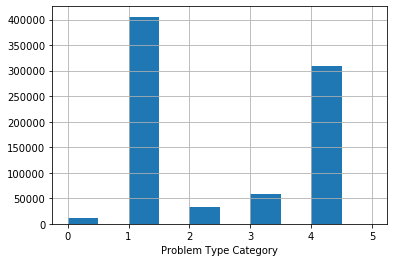

In [40]:
import matplotlib.pyplot as plt
new_df['type_cat'].hist()
plt.xlabel("Problem Type Category")

Since our dataset is not evenly distributed among problem types, we will ignore this feature when we train our model.

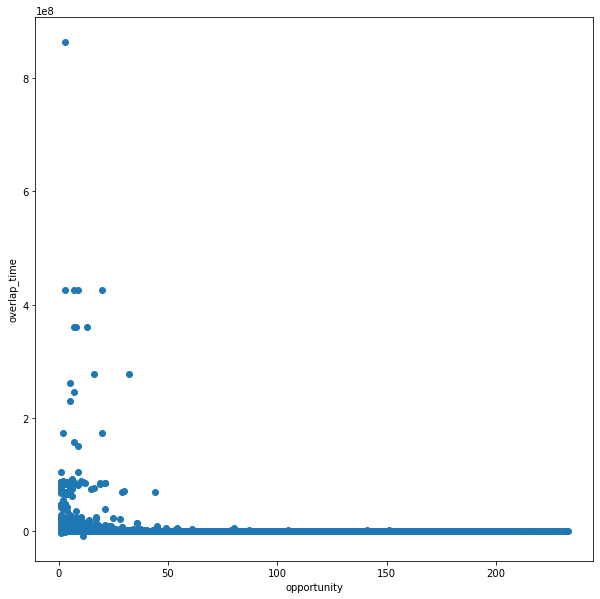

In [41]:
hint_count = new_df['opportunity']
overlap_time = new_df['overlap_time']

plt.figure(figsize=(10, 10))
plt.scatter(hint_count,overlap_time)
plt.xlabel("opportunity")
plt.ylabel("overlap_time")
plt.show()

We can see that the more opportunity a student gets to practice a problem, the less overlap time it takes to solve the problem.

We will now try to visualize the portion of answer types.

In [42]:
new_df.groupby('answer_type_cat').count()

,order_id,user_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode_cat,sequence_id,position,...,skill_id,teacher_id,school_id,hint_count,hint_total,overlap_time,first_action,opportunity,opportunity_original,lag (t-1)
answer_type_cat,,,,,,,,,,,,,,,,,,,,,
0.0,297204,297204,297204,297204,297204,297204,297204,297204,297204,297204,...,297204,297204,297204,297204,297204,297204,297204,297204,297204,87165
1.0,359280,359280,359280,359280,359280,359280,359280,359280,359280,359280,...,359280,359280,359280,359280,359280,359280,359280,359280,359280,117108
2.0,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,0
3.0,156670,156670,156670,156670,156670,156670,156670,156670,156670,156670,...,156670,156670,156670,156670,156670,156670,156670,156670,156670,44800
4.0,1793,1793,1793,1793,1793,1793,1793,1793,1793,1793,...,1793,1793,1793,1793,1793,1793,1793,1793,1793,1215
5.0,164,164,164,164,164,164,164,164,164,164,...,164,164,164,164,164,164,164,164,164,0


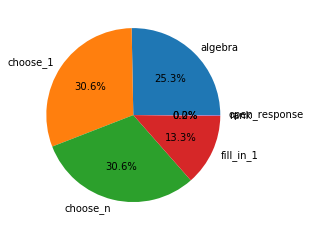

In [43]:
problem_type = ('algebra', 'choose_1', 'choose_n', 'fill_in_1','open_response', 'rank')

a= len(new_df[new_df['answer_type_cat']== 0.0])
b= len(new_df[new_df['answer_type_cat']== 1.0])
c= len(new_df[new_df['answer_type_cat']== 2.0])
d= len(new_df[new_df['answer_type_cat']== 3.0])
e= len(new_df[new_df['answer_type_cat']== 4.0])
f= len(new_df[new_df['answer_type_cat']== 5.0])
count = (a, b, b, d, e,f)

plt.pie(
    count,
    labels=problem_type,
    autopct='%1.1f%%',
)
plt.show()

We can see our data set has a very small portion of 'choose_n' and 'rank' type problem. This can make our model biased if we use this feature and we will not be able to correctly predict data that has 'choose_n' and 'rank' type problem in them.

In [44]:
new_df.shape

(815144, 22)

### Data Preprocessing

In [47]:
target_column = 'correct'
feature_columns = ["problem_id", "original", "attempt_count", "ms_first_response", 
            "tutor_mode_cat", "sequence_id", "skill_id", "teacher_id", 
            "school_id","hint_count", "hint_total", "overlap_time", "first_action", "opportunity",
            "opportunity_original"]

X = new_df[feature_columns]
y = new_df[target_column]

# 75% train data, 25% test data
X_train, X_test, y_train, y_test = X.iloc[:600000 , :], X.iloc[600000: , :], y[:600000], y[600000:]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform (X_test)


### Logistic Regression and GridSearchCV

In [57]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()

# Source - https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
from sklearn.model_selection import GridSearchCV
space = dict()
space['solver'] = ['newton-cg', 'lbfgs']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
search = GridSearchCV(LR, space, scoring='accuracy', n_jobs=-1,cv=2)
result = search.fit(X_train, y_train)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/home/michael/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Score: 0.898675
Best Hyperparameters: {'C': 1e-05, 'penalty': 'none', 'solver': 'newton-cg'}


/home/michael/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


We see that we get a best score with Hyperparameters: {'C': 1e-05, 'penalty': 'none', 'solver': 'newton-cg'}. So, will use them in our model.

#### LogisticRegression Model Training and ROC Curve

/home/michael/.local/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/michael/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Logistic: ROC AUC=0.818


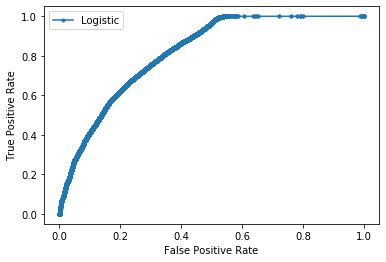

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score

LR = LogisticRegression(C=1e-05, solver='newton-cg').fit(X_train,y_train)
lr_probs = LR.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('Logistic: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

We can see from the roc_auc score that the performace of our model is fairly good and the model can fairly distinguish between the classes.

#### Confusion matrix

In [59]:
from sklearn.metrics import confusion_matrix
y_pred1 = LR.predict(X_test)
print(confusion_matrix(y_test, y_pred1))

[[ 40299  50759]
 [    26 124060]]


From the confusion matrix we can see that TN is high meaning our model can correctly predict negative class. But our model cannot predict the positive class properly since TP is lower than FP.

#### Visualizing significant coefficients

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

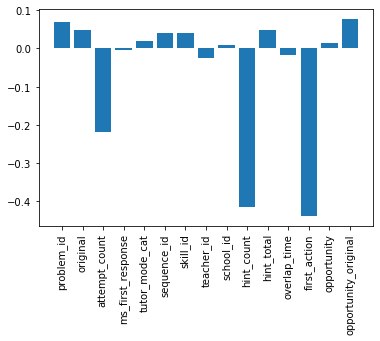

In [55]:
import numpy as np
plt.bar(np.arange(15),LR.coef_[0],tick_label=feature_columns)
plt.xticks(rotation=90)

The most significant variables are - 'opportunity_originals', 'problem_id'

### RandomForestClassifier and GridsearchCV

In [56]:
from sklearn.ensemble import RandomForestClassifier

rfr = RandomForestClassifier(random_state = 1)
param_grid = {  'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}
g_search = GridSearchCV(estimator = rfr, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 0, return_train_score=True)
result = g_search.fit(X_train, y_train);
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8204583333333333
Best Hyperparameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 15}


We see that we get a best score with Hyperparameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 13}. So, will use them in our model.

#### RandomForest Model Training and ROC Curve

Random Forest: ROC AUC=0.924


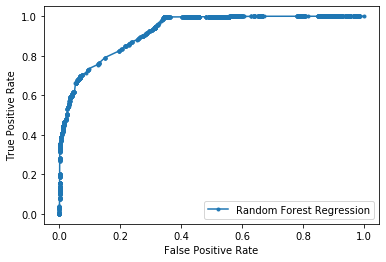

In [60]:
rfr = RandomForestClassifier(bootstrap=True, max_depth=5, max_features='auto',n_estimators=13).fit(X_train,y_train)
rfr_probs = rfr.predict_proba(X_test)
rfr_probs = rfr_probs[:, 1]
rfr_auc = roc_auc_score(y_test, rfr_probs)
print('Random Forest: ROC AUC=%.3f' % (rfr_auc))
rfr_fpr, rfr_tpr, _ = roc_curve(y_test, rfr_probs)
plt.plot(rfr_fpr, rfr_tpr, marker='.', label='Random Forest Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

We can see from the roc_auc score that it is close to 1 which is better than our logistic regression model. The performace of our model is very good and the model can distinguish between the classes.

#### Confusion matrix

In [61]:
y_pred2 = rfr.predict(X_test)
print(confusion_matrix(y_test, y_pred2))

[[ 59786  31272]
 [   483 123603]]


From the confusion matrix we can see that TN is high meaning our model can correctly predict negative class.Our model can also predict the positive class properly since TP is higer than FP.

#### Visualize important features

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 <a list of 9 Text xticklabel objects>)

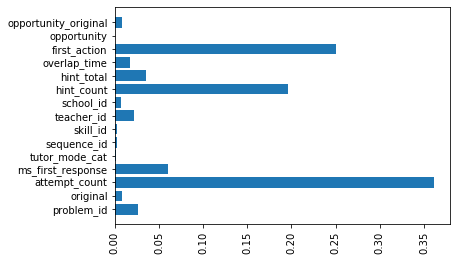

In [62]:
plt.barh(np.arange(15),rfr.feature_importances_,tick_label=feature_columns)
plt.xticks(rotation=90)

The most important features are - 'attempt_count', 'hint_count', 'first_action'.

### Neural Network Model

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(12, input_dim=15, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=100, batch_size=10000)

Epoch 1/100
60/60 [==============================] - 2s 19ms/step - loss: 0.7331 - accuracy: 0.5609 - val_loss: 0.6397 - val_accuracy: 0.6427
Epoch 2/100
60/60 [==============================] - 1s 9ms/step - loss: 0.6062 - accuracy: 0.6872 - val_loss: 0.5475 - val_accuracy: 0.7360
Epoch 3/100
60/60 [==============================] - 1s 9ms/step - loss: 0.5381 - accuracy: 0.7306 - val_loss: 0.5056 - val_accuracy: 0.7521
Epoch 4/100
60/60 [==============================] - 1s 9ms/step - loss: 0.4979 - accuracy: 0.7472 - val_loss: 0.4834 - val_accuracy: 0.7595
Epoch 5/100
60/60 [==============================] - 1s 9ms/step - loss: 0.4626 - accuracy: 0.7677 - val_loss: 0.4635 - val_accuracy: 0.7669
Epoch 6/100
60/60 [==============================] - 1s 9ms/step - loss: 0.4270 - accuracy: 0.7865 - val_loss: 0.4408 - val_accuracy: 0.7761
Epoch 7/100
60/60 [==============================] - 1s 9ms/step - loss: 0.3998 - accuracy: 0.8057 - val_loss: 0.4254 - val_accuracy: 0.7828
Epoch 8/100


Epoch 59/100
60/60 [==============================] - 1s 9ms/step - loss: 0.3216 - accuracy: 0.8363 - val_loss: 0.3871 - val_accuracy: 0.7782
Epoch 60/100
60/60 [==============================] - 1s 9ms/step - loss: 0.3199 - accuracy: 0.8370 - val_loss: 0.3920 - val_accuracy: 0.7654
Epoch 61/100
60/60 [==============================] - 1s 9ms/step - loss: 0.3210 - accuracy: 0.8358 - val_loss: 0.3919 - val_accuracy: 0.7744
Epoch 62/100
60/60 [==============================] - 1s 9ms/step - loss: 0.3203 - accuracy: 0.8368 - val_loss: 0.3928 - val_accuracy: 0.7662
Epoch 63/100
60/60 [==============================] - 1s 9ms/step - loss: 0.3212 - accuracy: 0.8361 - val_loss: 0.3823 - val_accuracy: 0.7806
Epoch 64/100
60/60 [==============================] - 1s 9ms/step - loss: 0.3198 - accuracy: 0.8377 - val_loss: 0.3888 - val_accuracy: 0.7746
Epoch 65/100
60/60 [==============================] - 1s 9ms/step - loss: 0.3213 - accuracy: 0.8366 - val_loss: 0.3976 - val_accuracy: 0.7605
Epoch 

We can plot the accurcay of train and test datadests for different epoch values and see that optimial epoch value.

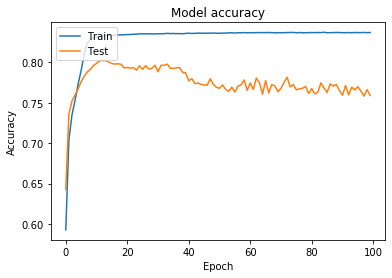

In [64]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

We can see that the optimal value for epoch is close to 10. After that the accuracy for test data set starts going down.

#### Roc Curve for Neural Network Model

Neural Network: AUC=0.883


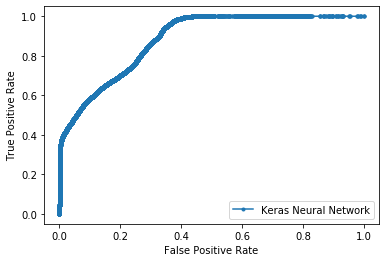

In [65]:
from sklearn.metrics import auc
y_pred3 = model.predict(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
auc = auc(fpr, tpr)
print('Neural Network: AUC=%.3f' % (auc))

plt.plot(fpr, tpr, marker='.', label='Keras Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

We can see from the roc_auc score that the performace of our model is fairly good and the model can fairly distinguish between the classes.

#### Confusion matrix

In [66]:
# print(confusion_matrix(y_test, y_pred3))

# error - "Classification metrics can't handle a mix of binary and continuous targets"
# For some reason my y_pred3 predictions are float instead of binary 0,1.

#### LSTM Model

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np

X1_train, y1_train,X1_test,y1_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X1_train = np.reshape(X1_train, (X1_train.shape[0],X1_train.shape[1],1))
X1_test = np.reshape(X1_test, (X1_test.shape[0],X1_test.shape[1],1))

model = Sequential()

model.add(LSTM(units = 12, return_sequences = True, input_shape = (X1_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 12, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 12, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 12))
model.add(Dropout(0.2))
model.add(Dense(units = 2))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X1_train, y1_train,validation_data = (X1_test,y1_test), epochs=15, batch_size=100000)

Epoch 1/15
6/6 [==============================] - 84s 11s/step - loss: 2.5830 - accuracy: 0.4939 - val_loss: 0.6935 - val_accuracy: 0.4591
Epoch 2/15
6/6 [==============================] - 56s 10s/step - loss: 0.7385 - accuracy: 0.5091 - val_loss: 0.6931 - val_accuracy: 0.4356
Epoch 3/15
6/6 [==============================] - 46s 7s/step - loss: 0.7015 - accuracy: 0.4922 - val_loss: 0.6931 - val_accuracy: 0.4259
Epoch 4/15
6/6 [==============================] - 51s 9s/step - loss: 0.6983 - accuracy: 0.4846 - val_loss: 0.6931 - val_accuracy: 0.4232
Epoch 5/15
6/6 [==============================] - 43s 7s/step - loss: 0.6967 - accuracy: 0.4809 - val_loss: 0.6931 - val_accuracy: 0.4232
Epoch 6/15
6/6 [==============================] - 40s 7s/step - loss: 0.6960 - accuracy: 0.4782 - val_loss: 0.6931 - val_accuracy: 0.4232
Epoch 7/15
6/6 [==============================] - 40s 7s/step - loss: 0.6956 - accuracy: 0.4759 - val_loss: 0.6931 - val_accuracy: 0.4232
Epoch 8/15
6/6 [================

We can plot the accurcay of train and test datadests for different epoch values and find the optimial epoch value.

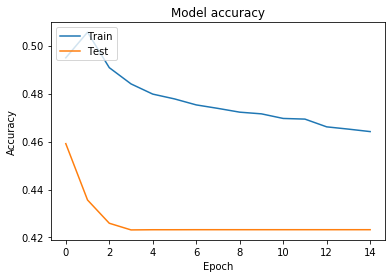

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

We can see that the optimal value for epoch is close to 1. After that the accuracy for test data set starts going down. We can also notice that our test accurcay is higher than our training accuracy.

#### LSTM and ROC Curve

LSTM: AUC=0.883


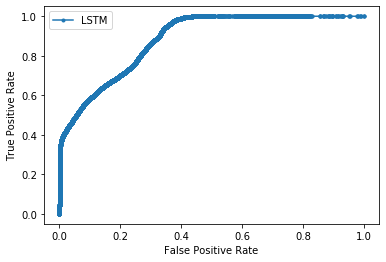

In [69]:
from sklearn.metrics import auc

y_pred4 = model.predict(X1_test)[:, 1]
fpr2, tpr2, thresholds2 = roc_curve(y1_test, y_pred4)
auc_keras= auc(fpr, tpr)
print('LSTM: AUC=%.3f' % (auc_keras))

plt.plot(fpr, tpr, marker='.', label='LSTM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

We can see that the roc_score is very low which is a bad sign and means that our model cannot distinguish between classes properly.

#### Confusion matrix

In [70]:
# print(confusion_matrix(y1_test, y_pred4))

#### All ROC Curves on One Graph

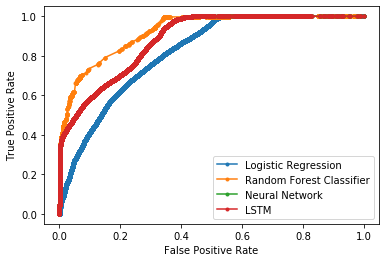

In [71]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

rfr_fpr, rfr_tpr, _ = roc_curve(y_test, rfr_probs)
plt.plot(rfr_fpr, rfr_tpr, marker='.', label='Random Forest Regression')

fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
plt.plot(fpr, tpr, marker='.', label='Keras Neural Network')

fpr2, tpr2, thresholds2 = roc_curve(y1_test, y_pred4)
plt.plot(fpr, tpr, marker='.', label='LSTM')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(["Logistic Regression", "Random Forest Classifier","Neural Network", "LSTM"])
plt.show()

From the ROC curve, we can tell that our Random forest Classifier can distinguish between classes better than any other models that we have. Logistic regression performs the least amount.

In [72]:
import shap

explainer = shap.Explainer(rfr, X_test)
shap_values = explainer(X_test)

100%|===================| 428375/430288 [02:50<00:00]        

In [73]:
shap.plots.beeswarm(shap_values )
# For some reason I was getting errors in this step. So I couln't visualize the beeswarm plot.

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

Different interpretability methods didn't provide the same results. After watching both coef_ and feature_importance_ graphs, I am noticing that the first is prioritizing positively correlated features and the second one is prioritizing negatively correlated features

### Conclusion

If I had more time, i would have definitely tuned with the feature sets more. Some of the features may not be necessary. I would have done some correlation calculation to find out the important features. I would find ways to improve the lag features as well.